# 2. Data Acquisition and Cleaning

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Aquisition

This project looks at 2 independent datasets that were downloaded raw from the website __[kaggle.com](http://www.kaggle.com)__. Their versions are the present ones as of 10 August 2022. The datasets contain information about the daily weather [__[1](https://www.kaggle.com/datasets/vanvalkenberg/historicalweatherdataforindiancities)__] and power consumption [__[2](https://www.kaggle.com/datasets/twinkle0705/state-wise-power-consumption-in-india)__] in 6 major states in the country of India over a couple of years. They can be found in the folder data &rarr; raw. This notebook examines the raw datasets and cleans them separately such that they are appropriate for the analytics in the later parts of the project.

In [3]:
raw_data = "data/raw"

## Weather

I begin with the data about the weather. It originally contains 6 csv files, each referring to the biggest weather station in the cities Bangalore, Chennai, Delhi, Lucknow, Mumbai, and Rajasthan from 1990 to 2022. For convenience, I extract the cities and their respective provinces in a python dictionary.

In [4]:
states_and_cities = {
    "Karnataka": "Bangalore",
    "Tamil Nadu": "Chennai",
    "Delhi": "Delhi",
    "Uttar Pradesh": "Lucknow", 
    "Maharashtra": "Mumbai",
    "Rajasthan": "Rajasthan"}

I read the 6 files in a list.

In [5]:
weather_data_all = [pd.read_csv(raw_data + "/weather/" + city + ".csv") for city in states_and_cities.values()]

Each file contains 5 columns: the date of the observation, the mean, maximum, and minimum temperature for that day in °C and the precipitation value in millimiters.

In [6]:
weather_data_all[0].head()

,time,tavg,tmin,tmax,prcp
0,01-01-1990,22.9,19.1,28.4,NaN
1,02-01-1990,21.7,NaN,26.5,0.0
2,03-01-1990,21.0,16.4,26.5,0.0
3,04-01-1990,20.8,NaN,27.4,0.0
4,05-01-1990,20.4,14.2,26.1,0.0


I add the corresponding state as a column because the dataframes will be merged together and that way the state is preserved.

In [7]:
for i in range(len(weather_data_all)):
    weather_data_all[i]["state"] = list(states_and_cities.keys())[i]

I know inspect for any missing values.

In [8]:
for df in weather_data_all:
    print(df.state[0] + " missing values:")
    print(df.isnull().sum()[["tavg", "tmin", "tmax", "prcp"]])
    print()

Karnataka missing values:
tavg      70
tmin    1389
tmax     629
prcp    4620
dtype: int64

Tamil Nadu missing values:
tavg      27
tmin    3084
tmax    1019
prcp    4886
dtype: int64

Delhi missing values:
tavg      94
tmin    1536
tmax     533
prcp    6140
dtype: int64

Uttar Pradesh missing values:
tavg     138
tmin    3515
tmax    1553
prcp    6152
dtype: int64

Maharashtra missing values:
tavg      11
tmin    2454
tmax    1907
prcp    4681
dtype: int64

Rajasthan missing values:
tavg      70
tmin    1389
tmax     629
prcp    4620
dtype: int64



It appears that there are missing values in all numeric columns. They needto be handled.

For the columns that denote temperature, we can check if we can interpolate. That is, check if we can approximate the temperature today as the average of the temperature tomorrow and the temperature today. We would imagine that this is appropriate, since maximal, minimal, and mean temperatures usually do not change significantly day by day. To check that, we can subtract each datapoint from its respective datapoint tomorrow and repeat that for every state. If the resulting population has mean value and standard deviation both close to 0, we can conclude that each datapoint is similar to its neighbors and it would be appropriate to interpolate. 

In [9]:
def subtract_neighbors(x):
    result = x - np.roll(x, 1)
    return "mean: " + str(result.mean()) + "; standard deviation: " + str(result.std())

In [10]:
for df in weather_data_all:
    print(df["state"][0])
    print("Minimal temperature differences: " + subtract_neighbors(df["tmin"]))
    print("Mean temperature differences: " + subtract_neighbors(df["tavg"]))
    print("Maximal temperature differences: " + subtract_neighbors(df["tmax"]))
    print()

Karnataka
Minimal temperature differences: mean: 0.06703952274422074; standard deviation: 1.1207495184454854
Mean temperature differences: mean: -0.0010367097212780427; standard deviation: 0.9884867673593898
Maximal temperature differences: mean: 0.003571428571428568; standard deviation: 1.3417163144630424

Tamil Nadu
Minimal temperature differences: mean: 0.17843193566915563; standard deviation: 1.1589178962832745
Mean temperature differences: mean: 0.0004220121539500341; standard deviation: 0.9463741493464037
Maximal temperature differences: mean: -0.004678998911860719; standard deviation: 1.399206509662877

Delhi
Minimal temperature differences: mean: 0.18142576847612818; standard deviation: 1.747133421810153
Mean temperature differences: mean: 0.000562659846547317; standard deviation: 1.5674288414559576
Maximal temperature differences: mean: 0.0056524518308830205; standard deviation: 1.9345920980101354

Uttar Pradesh
Minimal temperature differences: mean: 0.20311610486891388; stand

That seems to be the case. The mean values are all close to 0 and the standard deviations are mostly around 1. It is noteable that some deviations from the mean in the resulting populations can be caused by the multiple missing values. I conclude that it is appropriate to interpolate.

In [11]:
for df in weather_data_all:
    df["tavg"] = df["tavg"].interpolate()
    df["tmin"] = df["tmin"].interpolate()
    df["tmax"] = df["tmax"].interpolate()

Now I handle the missing values in the precipitation columns. The case here is different because naturally the amount of rain can vary from day to day. We might consider replacing the missing values with the mean precipitation for state. To check if that is appropriate I plot the distribution of the precipitation for each state.

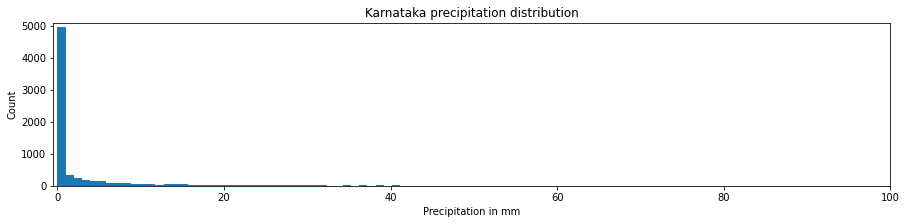

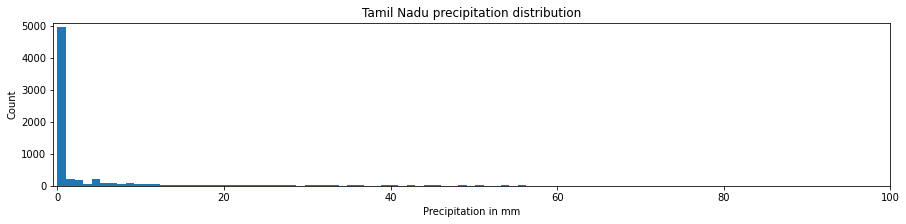

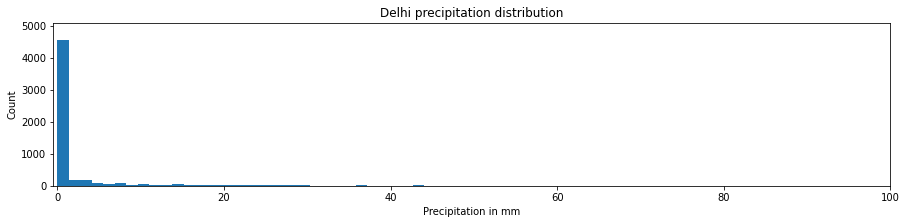

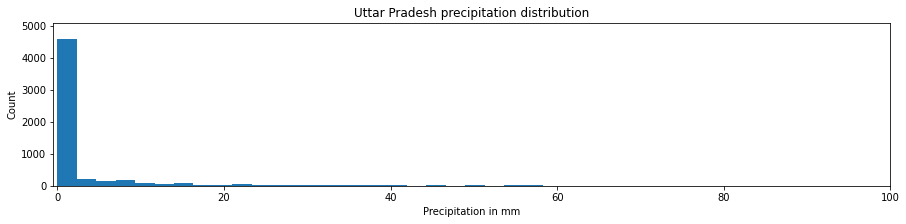

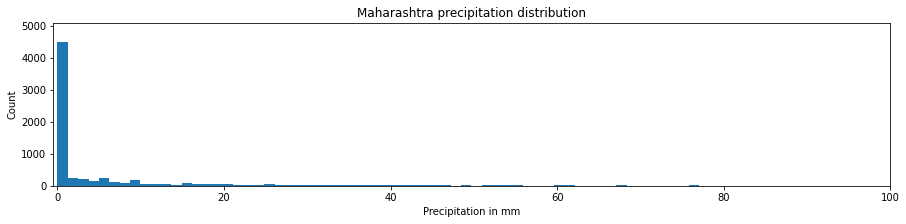

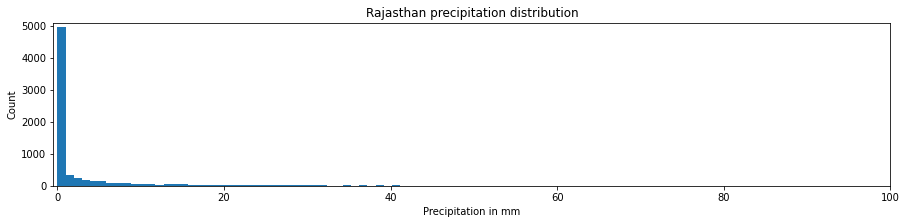

In [12]:
for df in weather_data_all:
    plt.figure(figsize=(15,3))
    plt.hist(df["prcp"], bins = df["prcp"].nunique())
    plt.xlim(-0.5,100)
    plt.ylim(0,5100)
    plt.xlabel("Precipitation in mm")
    plt.ylabel("Number of days")
    plt.title(df["state"][0] + " precipitation distribution")
    plt.show()

It appears that all distributions are very skewed to the right and there are some outliers. For such distributions, the median value is much more descriptive. Therefore, I use the median value for each state to replace the missing precipitation values.

In [13]:
for df in weather_data_all:
    df["prcp"] = df["prcp"].fillna(df["prcp"].median())

I have handled the missing values and now the dataframes can be merged into one.

In [14]:
weather_data = pd.concat(weather_data_all, ignore_index = True)

I check to confirm that all missing values have been removed.

In [15]:
weather_data.isnull().sum()

time     0
tavg     0
tmin     2
tmax     1
prcp     0
state    0
dtype: int64

It appears that there are a few missing values remaining. I handle them manually.

In [16]:
weather_data[(weather_data["tmin"].isna()) | (weather_data["tmax"].isna())]

,time,tavg,tmin,tmax,prcp,state
35682,01-01-1990,7.2,NaN,18.1,0.0,Uttar Pradesh
35683,02-01-1990,10.5,NaN,17.2,0.0,Uttar Pradesh
47576,01-01-1990,23.2,17.0,NaN,0.0,Maharashtra


It appears that the missing values for the temperature are the very first values in the dataframe for their respective states. It makes sense that they remain missing after interpolation since they have at most 1 neighbor. I replace the missing values with their neighbor in the column.

In [17]:
weather_data[weather_data["tmin"].isna()].index, weather_data[weather_data["tmax"].isna()].index

(Int64Index([35682, 35683], dtype='int64'), Int64Index([47576], dtype='int64'))

In [18]:
weather_data.at[35683, "tmin"] = weather_data.at[35684, "tmin"]
weather_data.at[35682, "tmin"] = weather_data.at[35683, "tmin"]
weather_data.at[47576, "tmax"] = weather_data.at[47577, "tmax"]

Now that I have filled all of the missing values, I can check the datatypes of the columns

In [19]:
weather_data.dtypes

time      object
tavg     float64
tmin     float64
tmax     float64
prcp     float64
state     object
dtype: object

I change the type of the columns of type *object* with a more appropriate type. Then I sort the rows by date and state.

In [20]:
weather_data["state"] = weather_data["state"].astype("string")
weather_data["time"] = pd.to_datetime(weather_data["time"], format = '%d-%m-%Y')
weather_data = weather_data.rename(columns = {"time" : "date"})
weather_data = weather_data.sort_values(by=["date", "state"],ascending=True, ignore_index = True)

In [21]:
weather_data

,date,tavg,tmin,tmax,prcp,state
0,1990-01-01,9.4,6.0,15.1,0.0,Delhi
1,1990-01-01,22.9,19.1,28.4,0.0,Karnataka
2,1990-01-01,23.2,17.0,29.9,0.0,Maharashtra
3,1990-01-01,22.9,19.1,28.4,0.0,Rajasthan
4,1990-01-01,25.2,22.8,28.4,0.5,Tamil Nadu
...,...,...,...,...,...,...
71359,2022-07-25,24.1,20.2,28.5,0.5,Karnataka
71360,2022-07-25,28.3,25.1,30.2,7.1,Maharashtra
71361,2022-07-25,24.1,20.2,28.5,0.5,Rajasthan
71362,2022-07-25,28.1,25.4,32.6,2.9,Tamil Nadu


I also check for any skipped dates in the dataframe.

In [22]:
def check_missing_dates(df):
    dates_range = pd.date_range(start = min(df["date"]), end = max(df["date"]))
    for name, group in df.groupby("state"):
        diff = dates_range.difference(group["date"])
        print(name)
        print(diff)
        print()

In [23]:
check_missing_dates(weather_data)

Delhi
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Karnataka
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Maharashtra
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Rajasthan
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Tamil Nadu
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Uttar Pradesh
DatetimeIndex([], dtype='datetime64[ns]', freq='D')



It appears that there are not any.

The dataset is now fully cleaned and I can move on to the next one.

## Power

The second dataset contains information about the power consumption in major Indian cities from 2 Jan 2019 to 5 Dec 2020 measured in Mega Units (MU). 

In [24]:
power_data = pd.read_csv(raw_data + "/power.csv")

In [25]:
power_data

,Unnamed: 0,Punjab,Haryana,Rajasthan,Delhi,UP,Uttarakhand,HP,J&K,Chandigarh,...,Odisha,West Bengal,Sikkim,Arunachal Pradesh,Assam,Manipur,Meghalaya,Mizoram,Nagaland,Tripura
0,02/01/2019 00:00:00,119.9,130.3,234.1,85.8,313.9,40.7,30.0,52.5,5.0,...,70.2,108.2,2.0,2.1,21.7,2.7,6.1,1.9,2.2,3.4
1,03/01/2019 00:00:00,121.9,133.5,240.2,85.5,311.8,39.3,30.1,54.1,4.9,...,67.9,110.2,1.9,2.2,23.4,2.4,6.5,1.8,2.2,3.6
2,04/01/2019 00:00:00,118.8,128.2,239.8,83.5,320.7,38.1,30.1,53.2,4.8,...,66.3,106.8,1.7,2.2,21.7,2.4,6.3,1.7,2.2,3.5
3,05/01/2019 00:00:00,121.0,127.5,239.1,79.2,299.0,39.2,30.2,51.5,4.3,...,65.8,107.0,2.0,2.2,22.5,2.7,5.7,1.8,2.3,3.5
4,06/01/2019 00:00:00,121.4,132.6,240.4,76.6,286.8,39.2,31.0,53.2,4.3,...,62.9,106.4,2.0,2.2,21.7,2.7,6.2,1.9,2.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,01/12/2020 00:00:00,130.8,126.0,220.4,77.3,322.8,36.5,25.4,45.4,3.6,...,105.7,172.6,1.4,2.1,20.4,2.1,5.4,1.8,2.0,2.4
499,02/12/2020 00:00:00,129.4,127.3,218.4,81.3,331.4,37.0,25.8,45.2,3.7,...,112.3,174.4,1.5,2.1,23.3,2.4,5.4,1.6,2.1,3.3
500,03/12/2020 00:00:00,132.1,129.7,205.6,85.6,336.7,37.8,26.2,45.2,4.0,...,113.0,169.8,1.4,2.1,21.7,2.3,5.4,1.5,2.0,3.6
501,04/12/2020 00:00:00,132.1,128.4,207.0,83.9,334.6,38.2,27.0,43.0,4.0,...,111.6,145.5,1.2,2.0,24.2,2.5,5.7,1.6,2.0,3.3


In [26]:
power_data = power_data.rename(columns = {"UP": "Uttar Pradesh", "Unnamed: 0": "date"})

First of all, I filter the columns and use only the ones that represent states, for which there is data in the first dataset

In [27]:
cols = list(set(power_data.columns) & set(states_and_cities.keys()))
power_data = power_data[["date"] + cols]
power_data.head()

,date,Karnataka,Maharashtra,Delhi,Tamil Nadu,Rajasthan,Uttar Pradesh
0,02/01/2019 00:00:00,206.3,428.6,85.8,268.3,234.1,313.9
1,03/01/2019 00:00:00,212.2,419.6,85.5,285.2,240.2,311.8
2,04/01/2019 00:00:00,205.3,395.8,83.5,270.3,239.8,320.7
3,05/01/2019 00:00:00,212.4,411.1,79.2,286.8,239.1,299.0
4,06/01/2019 00:00:00,217.5,408.6,76.6,298.3,240.4,286.8


There was a comment on Kaggle stating that there are issues with the date column. Some dates have switched month and date values.

In [28]:
power_data["date"] = pd.to_datetime(power_data["date"], dayfirst = True)

In [29]:
power_data[power_data.duplicated(["date"], keep=False)]

,date,Karnataka,Maharashtra,Delhi,Tamil Nadu,Rajasthan,Uttar Pradesh
182,2019-07-08,196.4,380.5,57.8,253.7,171.8,280.3
183,2019-07-08,207.4,388.6,59.9,255.6,154.1,268.3
184,2019-07-09,207.2,399.1,56.8,255.0,163.0,260.2
185,2019-07-09,207.9,405.7,58.6,260.5,171.0,283.0
186,2019-07-10,205.5,410.2,59.9,261.7,167.2,284.4
187,2019-07-10,193.5,412.7,59.5,260.8,170.6,293.6
188,2019-07-11,198.2,404.4,62.2,259.0,168.0,296.3
189,2019-07-11,180.4,421.9,61.5,282.8,208.2,264.6
190,2019-07-12,183.5,429.8,62.6,291.4,211.8,268.3
191,2019-07-12,186.2,431.3,63.6,290.2,214.7,266.3


All of them are for the month of July and all dates are after the 8th. We can then assume that the incorrect dates are the second ones since the data for July is probably inserted before the duplicates.

In [30]:
index = 183
while index <= 191:
    val = power_data.at[index, "date"]
    power_data.at[index, "date"] = pd.Timestamp(year = val.year, month = val.day, day = val.month)
    index += 2

I notice that the columns contain the state and the values are the power consumption. I convert the dataframe from a wide format to a long format using `pandas.melt` because of convenience and the fact that it gets the same format as the other dataframe.

In [31]:
power_data = pd.melt(power_data, id_vars = "date", var_name = "state", value_name = "usage")
power_data.head()

,date,state,usage
0,2019-01-02,Karnataka,206.3
1,2019-01-03,Karnataka,212.2
2,2019-01-04,Karnataka,205.3
3,2019-01-05,Karnataka,212.4
4,2019-01-06,Karnataka,217.5


I now check for missing values.

In [32]:
power_data.isnull().sum()

date     0
state    0
usage    0
dtype: int64

It appears that there are not any, therefore, I move on.

I decide to use only a full year of datapoints since that way each month is represented equally and we can later see the relationship between months/seasons and the power consumption. Then I also filter the first dataframe such that it contains data for the same time interval and we can merge the two dataframes later.

In [33]:
first_date = min(power_data["date"])
last_date = pd.Timestamp(year=first_date.year + 1 , month=first_date.month, day=first_date.day - 1)
first_date, last_date

(Timestamp('2019-01-02 00:00:00'), Timestamp('2020-01-01 00:00:00'))

In [34]:
def strip(df, start, end):
    return df[(df["date"] >= start) & (df["date"] <= end)].sort_values(["date", "state"]).reset_index(drop = True)

In [35]:
power_data = strip(power_data, first_date, last_date)
weather_data = strip(weather_data, first_date, last_date)

I again check for any skipped dates.

In [36]:
check_missing_dates(power_data)

Delhi
DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)

Karnataka
DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)

Maharashtra
DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)

Rajasthan
DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)

Tamil Nadu
DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)

Uttar Pradesh
DatetimeIndex(['2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01'],
              dtype='datetime64[ns]', freq=None)



It appears that there are 5 dates missing, which are all in different months. Since that is a small number, I can just interpolate.

In [37]:
def fill_datetime_and_interpolate(df):
    groups = [gr.set_index("date").asfreq("D", fill_value = name).reset_index() for name, gr in df.groupby("state")]
    ret_df = pd.concat(groups)
    ret_df["usage"] = pd.to_numeric(ret_df["usage"], errors = "coerce")
    ret_df["usage"] = ret_df["usage"].interpolate()
    return ret_df.sort_values(by = ["date", "state"]).reset_index(drop = True)

In [38]:
power_data = fill_datetime_and_interpolate(power_data)
check_missing_dates(power_data)

Delhi
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Karnataka
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Maharashtra
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Rajasthan
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Tamil Nadu
DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Uttar Pradesh
DatetimeIndex([], dtype='datetime64[ns]', freq='D')



The dataframe is now fully cleaned and has the same format as the first one, so I can move on.

## Merging

Now that we have cleaned the dataframes, it is time to combine them into one and conclude the data acquisition and cleaning section.

In [39]:
data_all = power_data.merge(weather_data, on = ["date", "state"])

In [40]:
data_all.head()

,date,state,usage,tavg,tmin,tmax,prcp
0,2019-01-02,Delhi,85.8,13.8,6.5,23.0,0.0
1,2019-01-02,Karnataka,206.3,19.9,12.4,28.1,0.0
2,2019-01-02,Maharashtra,428.6,25.5,14.6,31.0,0.0
3,2019-01-02,Rajasthan,234.1,19.9,12.4,28.1,0.0
4,2019-01-02,Tamil Nadu,268.3,24.4,19.3,29.0,0.0


In [41]:
data_all.to_csv("data\cleaned\data_all.csv", index = None, header=True)